In [133]:
import pandas as pd 

import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

In [134]:
#daily energy consumption 
data = pd.read_csv('/Users/jack/Desktop/modern_ts/data/daily_dataset.csv')
#acorn data (demographics)
acorn_info  = pd.read_csv('/Users/jack/Desktop/modern_ts/data/informations_households.csv')

holidays = pd.read_csv('/Users/jack/Desktop/modern_ts/data/uk_bank_holidays.csv',
                         parse_dates=['Bank holidays']
                          )

#weather data 
weather = pd.read_csv('/Users/jack/Desktop/modern_ts/data/weather_daily_darksky.csv').infer_objects()



In [135]:
dates = [x for x in weather.columns if "Time" in x] # slice dt columns 

weather[dates] = weather[dates].apply(pd.to_datetime) # convert to datetime 

In [136]:
import re 
def clean_cols(col): 
    
    col = col.lower() 
    
    col = re.sub(r'\s+','_',col.strip())
    
    return col 

In [137]:
for df in [data, weather, holidays, acorn_info]: 
    
    df.columns = [clean_cols(x) for x in df.columns]

In [138]:
data = data.assign(ds = pd.to_datetime(data['day'])).set_index('ds')

data.lclid.nunique()

5566

In [139]:
#data['lclid']= data.lclid.astype('category') # convert unique id to category 

ts = data[['lclid','energy_sum']] # here is our timeseries with the category and target, we don't need the summary statistics, we can compute those

# lets inspect for null values.

In [140]:
ts.isna().sum() # we have 30 null values 

missing = ts.loc[ts.energy_sum.isna()].sort_index() # lets interpolate, first determining what method is appropriate 

missing

lclid  energy_sum
ds                               
2012-12-18  MAC000410         NaN
2012-12-18  MAC001300         NaN
2012-12-18  MAC001333         NaN
2012-12-18  MAC001150         NaN
2012-12-18  MAC005370         NaN
2012-12-18  MAC002155         NaN
2012-12-18  MAC000619         NaN
2012-12-18  MAC002275         NaN
2012-12-18  MAC002014         NaN
2012-12-18  MAC001957         NaN
2012-12-18  MAC001278         NaN
2012-12-18  MAC001229         NaN
2012-12-18  MAC001065         NaN
2012-12-18  MAC002110         NaN
2012-12-18  MAC001633         NaN
2012-12-18  MAC000393         NaN
2012-12-18  MAC005062         NaN
2012-12-19  MAC005559         NaN
2012-12-19  MAC005565         NaN
2012-12-19  MAC005556         NaN
2012-12-19  MAC005563         NaN
2012-12-19  MAC005558         NaN
2012-12-19  MAC005560         NaN
2013-01-04  MAC005037         NaN
2013-02-06  MAC004248         NaN
2013-02-13  MAC002796         NaN
2013-03-08  MAC001478         NaN
2013-04-16  MAC002629         NaN
2013-09-20  MAC005510         NaN
2013-10-29  MAC003559         NaN

Text(0.5, 1.0, 'Mean Target of Missing Series')

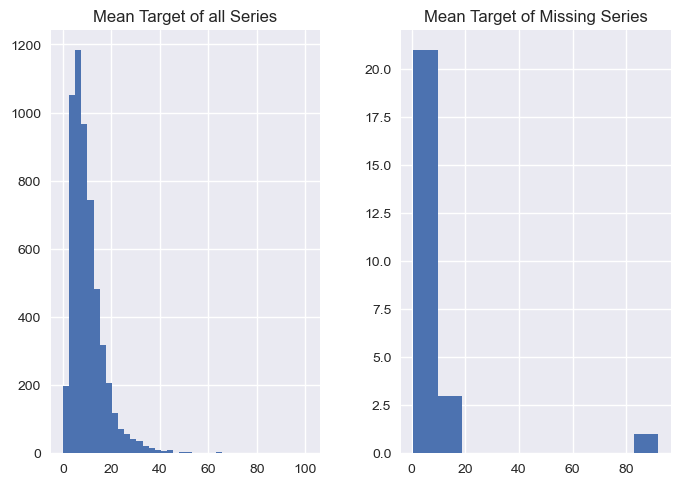

In [141]:
fig , ax = plt.subplots(ncols=2)

ts.groupby('lclid').mean().hist(column='energy_sum',
                                bins=40,
                                ax=ax[0]) # it looks like the average daily consumption is log normal for most series, how about our missing series? 

ts[ts.lclid.isin(missing.lclid.unique())].groupby('lclid').mean().hist(ax=ax[1])

ax[0].set_title('Mean Target of all Series')

ax[1].set_title('Mean Target of Missing Series')

In [142]:
# we see that we have an outlier at an average of 80 per day.

two_mo = ts.groupby('lclid').size() # lets ensure we forecast demand that atleast has 2 months history, other series will be discarded 


print(f'We have {np.sum(two_mo[two_mo > 60].index.nunique())} series with > 2 months of history')


ts = ts[ts.lclid.isin(two_mo[two_mo > 60].index)] # filter out sparse series 

We have 5556 series with > 2 months of history


Text(0.5, 1.0, 'Monthly Missing Value Matrix by Household')

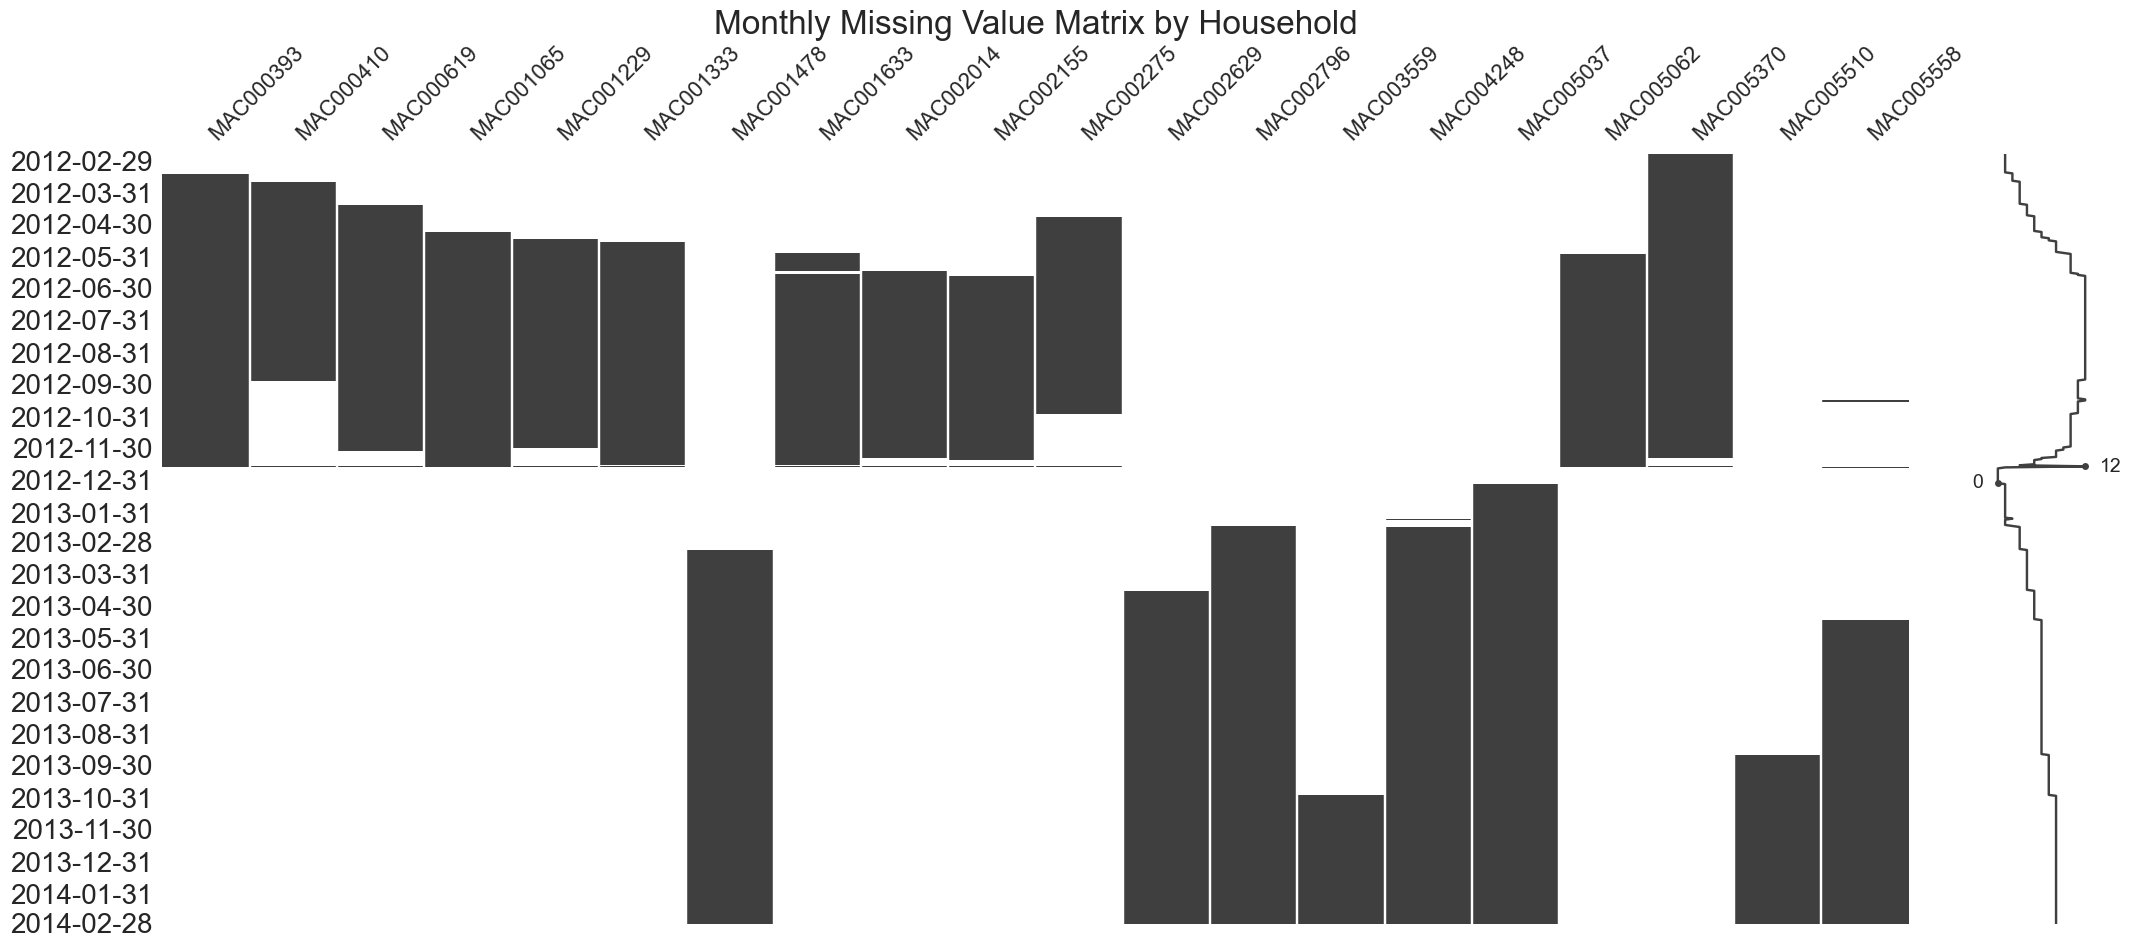

In [143]:
# i should've started with this, where are the missing values 

import missingno  as msno

#pivot data 

missing_ts = ts[ts.lclid.isin(missing.lclid)]

piv = missing_ts.pivot_table(index='ds',
               columns='lclid',
               values='energy_sum',
               aggfunc='sum').asfreq('D')

msno.matrix(piv,
            freq='M',
            ).set_title('Monthly Missing Value Matrix by Household',
                        fontsize=24)

* well we have some households with null values for the past 2 years, lets eliminate those from the dataset.

In [144]:
piv_filter = piv[piv.index.year.isin([2013])]

piv_filter = (piv_filter.isna().sum().sort_values() < 250)

missing_mask = piv_filter[~piv_filter].index # keep only these households out of missing

missing_mask # drop these 

Index(['MAC005510', 'MAC003559', 'MAC005370', 'MAC005062', 'MAC000393',
       'MAC002014', 'MAC001633', 'MAC001333', 'MAC001229', 'MAC001065',
       'MAC000619', 'MAC000410', 'MAC002275', 'MAC002155'],
      dtype='object', name='lclid')

In [145]:
ts = ts[~ts.lclid.isin(missing_mask)] # filter out missing series ids, I need to look into how to do that in fewer lines of code ^

<Axes: title={'center': 'Total Energy Consumption (London)'}, xlabel='ds'>

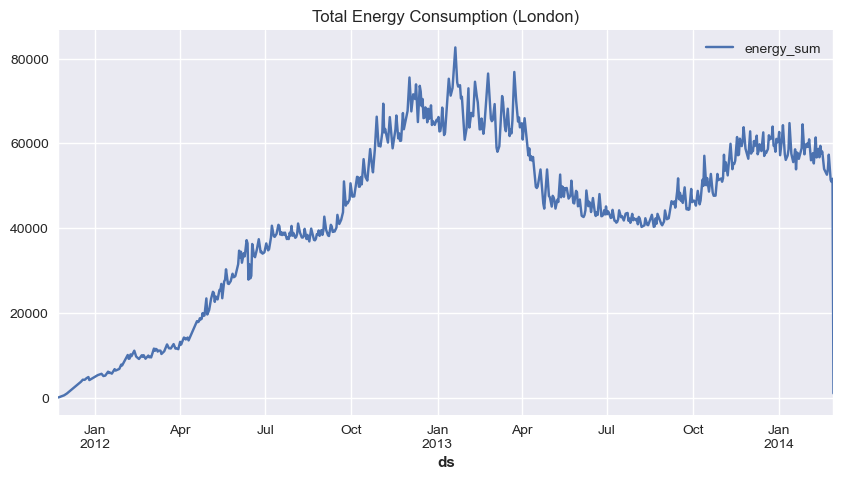

In [146]:
# lets first explore the aggregate series 

tot_ts = ts.resample("d").sum(numeric_only=True)

tot_ts.plot(title='Total Energy Consumption (London)',
            figsize=(10,5))

In [147]:
from sktime.transformations.series.date import DateTimeFeatures

dt_feats = DateTimeFeatures(ts_freq='D',
                 keep_original_columns=True,
                 feature_scope='efficient')

dt_tab = dt_feats.fit_transform(tot_ts)

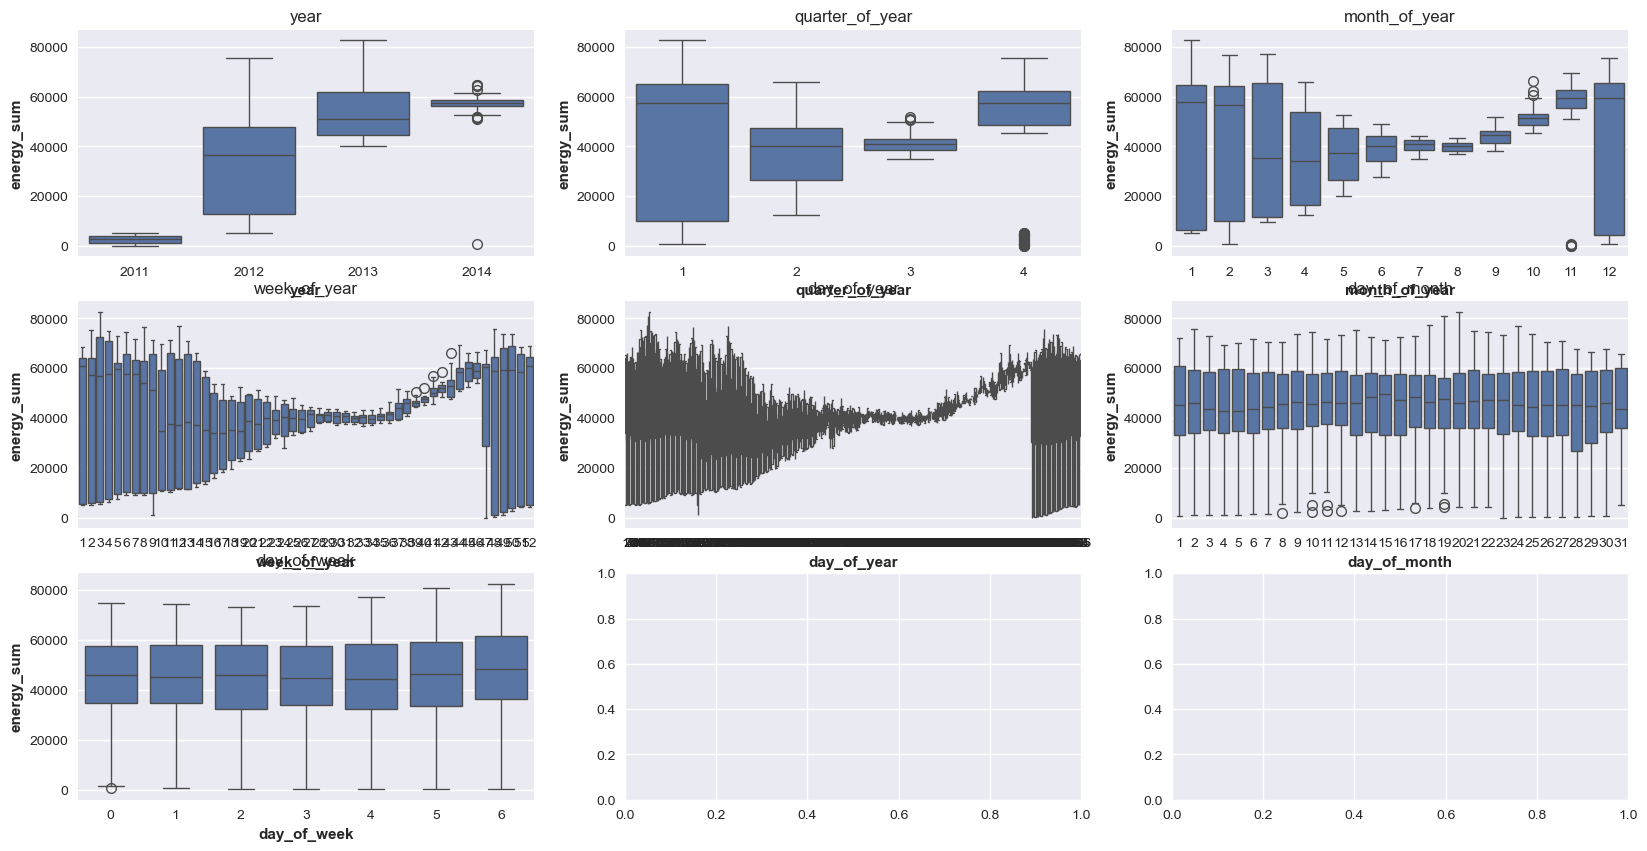

In [148]:
fig, ax = plt.subplots(figsize=(20,10),
                       ncols=3,
                       nrows=3)

ax = ax.flatten()

for i, date_feat in enumerate(dt_tab.drop('energy_sum',axis=1).columns):
    
    sns.boxplot(dt_tab,x=date_feat,y='energy_sum',
                ax=ax[i])\
        .set_title(date_feat)

we see strong seasonality, trend and some heteroskedasticity. Specifically very large variance in Dec, Jan, Feb and Mar

In [149]:
import plotly.express as px 

monthly_piv = dt_tab.pivot_table(index='month_of_year',
                   columns='day_of_month',
                   values='energy_sum',
                   aggfunc='mean')

px.imshow(img=monthly_piv,
          title='Do We Have Monthly Seasonality and Does it Change Across Months?')

In [150]:
#lets check for weekly seasonality across months 
weekly_piv = dt_tab.pivot_table(index='month_of_year',
                   columns='day_of_week',
                   values='energy_sum',
                   aggfunc='mean')

px.imshow(img=weekly_piv,
          title='Do We Have Weekly Seasonality and Does it Change Across Weeks?')

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>], dtype=object)

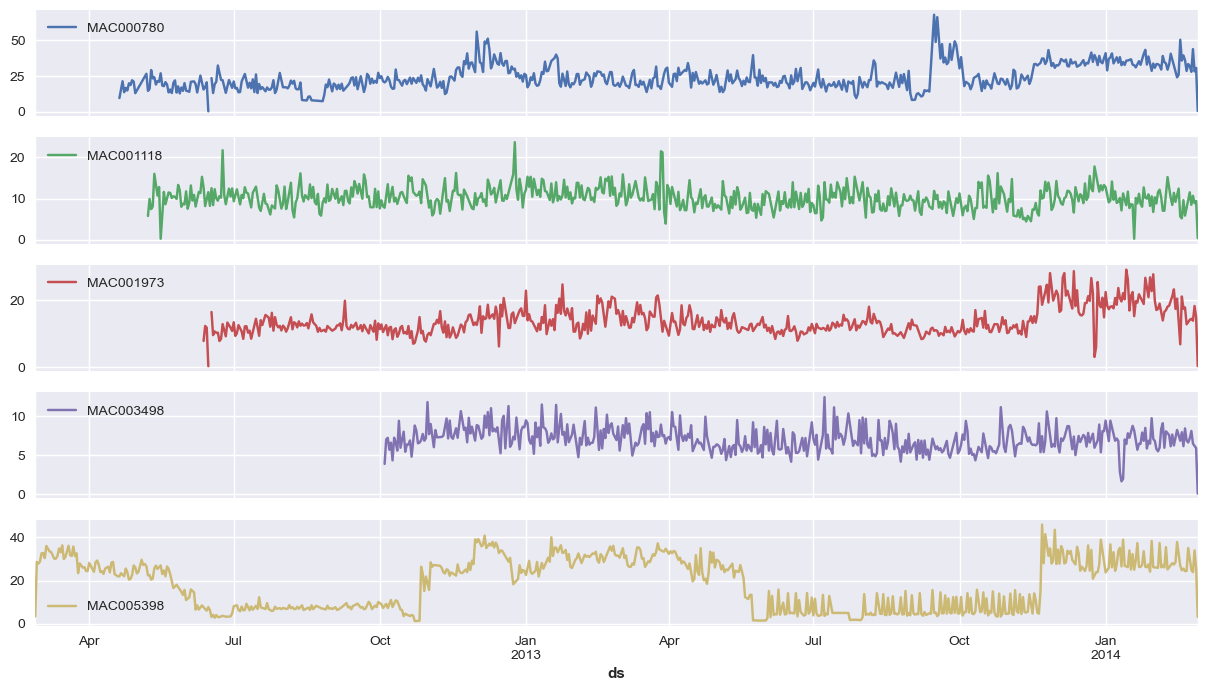

In [151]:
#now lets plot some randomly sampled series 

rand_ids = ts.lclid.sample(n=5).values.tolist()

ts.query('lclid in @rand_ids').pivot_table(index='ds',
                                           columns='lclid',
                                           values='energy_sum',
                                           aggfunc='sum').plot(subplots=True,
                                                               figsize=(15,8))

* we see a small bit of what we are working with but time to engineer some timeseries features.

* we can use these features as categoricals/static features or we can utilize them to partition the dataset for more efficient and faster training.

In [152]:
ts.rename(columns={'lclid':'unique_id','energy_sum':'y'},inplace=True)

* filling gaps in the series 

In [153]:
from utilsforecast.preprocessing import fill_gaps 

new_ts = fill_gaps(ts.reset_index(),
          freq='D',
          start='per_serie',
          end='per_serie'
          #start='global',
          #end='2014-02-27'
          )

In [154]:
# elimate all series that don't have end date within 1 week of max end date (we won't forecast these) 

new_ts.groupby('unique_id').ds.max().value_counts().sort_index() # we see we have quite a few series that ended a year ago... 

missing_mask = new_ts.groupby('unique_id').ds.max() <= '2014-02-21'


series_to_drop = missing_mask[missing_mask].index # we drop these series 

new_ts = new_ts.query('unique_id not in @series_to_drop')

* computing features via tsfel in the statistical and temporal domain, then clustering.

<Axes: title={'center': 'NaN Timeseries (Has Gaps)'}, xlabel='Number of Gaps', ylabel='unique_id'>

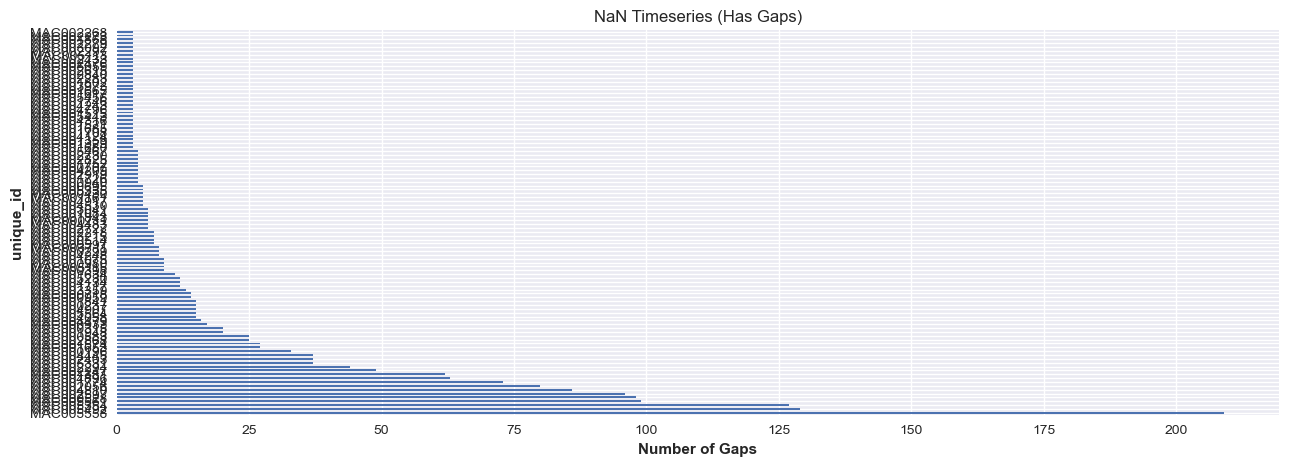

In [155]:
new_ts.loc[new_ts.y.isna()].groupby('unique_id').size().sort_values(ascending=False)[:100].plot(kind='barh',
                                                             title='NaN Timeseries (Has Gaps)',
                                                             figsize=(15,5),
                                                             xlabel='Number of Gaps') # anything less than a month lets ffill it 

In [156]:
missing_small = (new_ts.loc[new_ts.y.isna()].groupby('unique_id').size() < 30) & (new_ts.loc[new_ts.y.isna()].groupby('unique_id').size() > 0)

to_fill = new_ts[new_ts.unique_id.isin(missing_small[missing_small].index)]

new_ts.loc[to_fill.index,'y'] = new_ts.loc[to_fill.index].groupby('unique_id').y.ffill()

* lets examine gaps greater than 30 datapoints a bit closer.

Text(0.5, 1.0, 'Missing Values in Series > 30 Gaps')

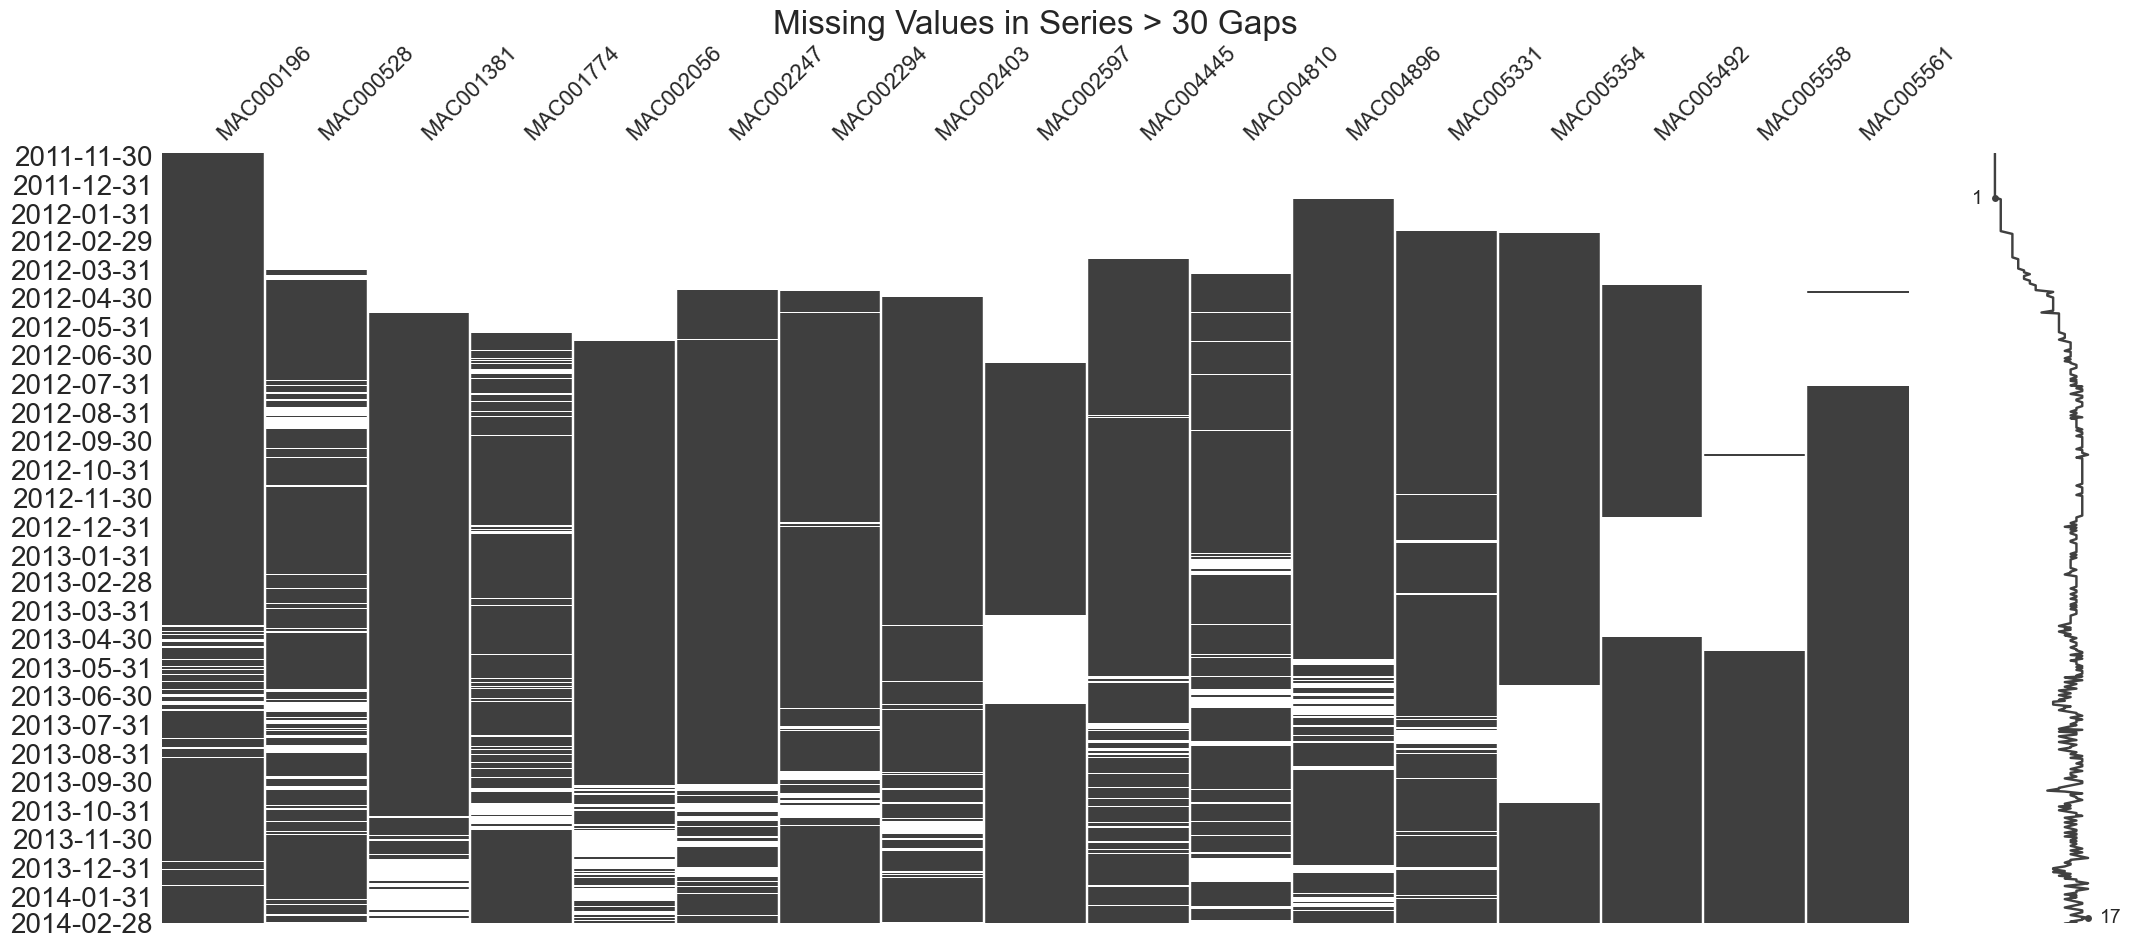

In [157]:
missing_lrg = (new_ts.loc[new_ts.y.isna()].groupby('unique_id').size() > 30)

missing = new_ts.loc[(new_ts.unique_id.isin(missing_lrg[missing_lrg].index))]

missing_piv = missing.pivot(index='ds',
              columns='unique_id',
              values='y').asfreq('D')

msno.matrix(missing_piv,
            freq='M').set_title('Missing Values in Series > 30 Gaps',fontsize=24)

# it looks like we have some small timeseries gaps and some very large, We can fill point nans with ffill, as for large gaps we need to seasonally interpolate 

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>], dtype=object)

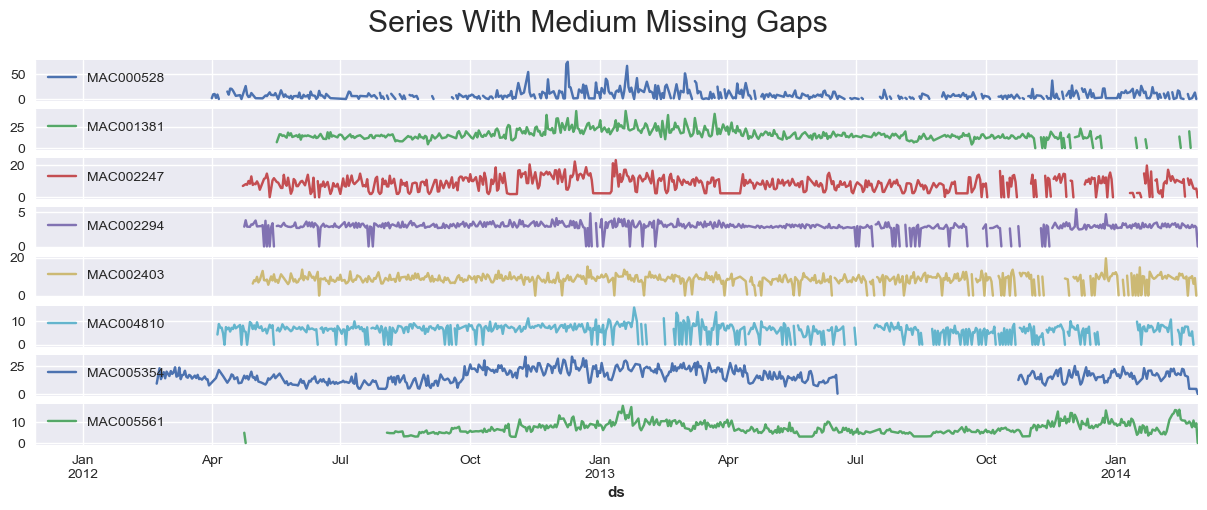

In [158]:
# we will have to handle these nan series a few at a time, small gap series can get ffill or linear interpolation,
# 
#  large gaps will need seasonal interpolation or to be truncated 

missing_prop = missing_piv.isna().mean()

large_gap = missing_prop[missing_prop >= .3].index

med_gap = missing_prop[(missing_prop >= .2) & (missing_prop < .3)].index

small_gaps = missing_prop[missing_prop < .1].index

new_ts[new_ts.unique_id.isin(small_gaps)] = new_ts[new_ts.unique_id.isin(small_gaps)].interpolate(method='linear')

missing_piv[med_gap].plot(subplots=True,title='Series With Medium Missing Gaps',
                          figsize=(15,5))

In [159]:
# we can ffill a few of these 

ffill_ts = ['MAC002247','MAC000528','MAC002294']

new_ts.loc[new_ts.unique_id.isin(ffill_ts),'y'] = new_ts[new_ts.unique_id.isin(ffill_ts)].groupby('unique_id').y.ffill()

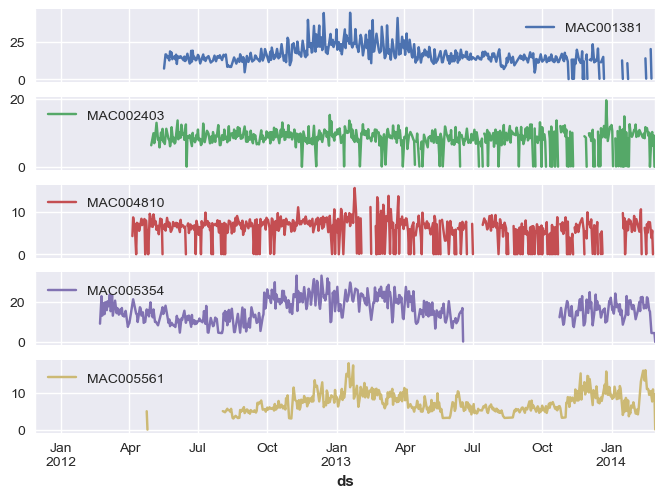

In [160]:
missing_piv[med_gap].drop(columns=ffill_ts).plot(subplots=True) 

# lets linearly interpolate MAC002403, MAC004810 and MAC001381, then seasonally interpolate MAC005354

linear_interp = ['MAC002403', 'MAC004810','MAC001381']

#groupby unique id then apply interpolate 
new_ts[new_ts.unique_id.isin(linear_interp)] = new_ts[new_ts.unique_id.isin(linear_interp)].apply(lambda x: x.interpolate())

In [161]:
group_id =  'MAC005354'

missing_idx = new_ts.loc[new_ts.unique_id == group_id,'y'].isna()

missing_idx = missing_idx[missing_idx].index

#shift 1 year 
shifted = new_ts.loc[new_ts.unique_id == group_id,'y'].shift(365)

#fill na 
new_ts.loc[new_ts.unique_id == group_id,'y'] = new_ts.loc[new_ts.unique_id == group_id,'y'].fillna(shifted)

import tsfel 
# Import tqdm and IPython display tools
from tqdm import tqdm_notebook
from tqdm.auto import tqdm

cfg = tsfel.get_features_by_domain('statistical') 

cfg = {**cfg,**tsfel.get_features_by_domain('temporal')}

uids = new_ts.unique_id.unique().tolist() 

stat_df = []

for id_ in tqdm(uids, desc='Gathering TS Features For All Households'): 

    subset = new_ts[new_ts.unique_id == id_][['y']]

    result = tsfel.time_series_features_extractor(cfg,
                                        subset,
                                        verbose=False)
    
    stat_df.append(result)

tsfel_feats = pd.concat(stat_df)

ts_feats = tsfel_feats.assign(unique_id = uids).set_index('unique_id')
#clean columns 
ts_feats.columns = [x.replace("y_",'') for x in ts_feats.columns]

ts_feats.head()

ts_feats.isna().sum() # fill this statistics with 0, I'm not sure why these feats didn't calculate but we will assume 0 for now, these series have adequate non null values 

#missing_feats = ts_feats[ts_feats['Absolute energy'].isna()].index.tolist()

#ts.query('unique_id in @missing_feats').groupby('unique_id').y.mean().hist()

ts_feats = ts_feats.fillna(0)

* we attempted to cluster on these variables generated above and the results weren't useable, maybe we can use these ts features later...

Text(0.5, 1.0, 'Feb 28 2014')

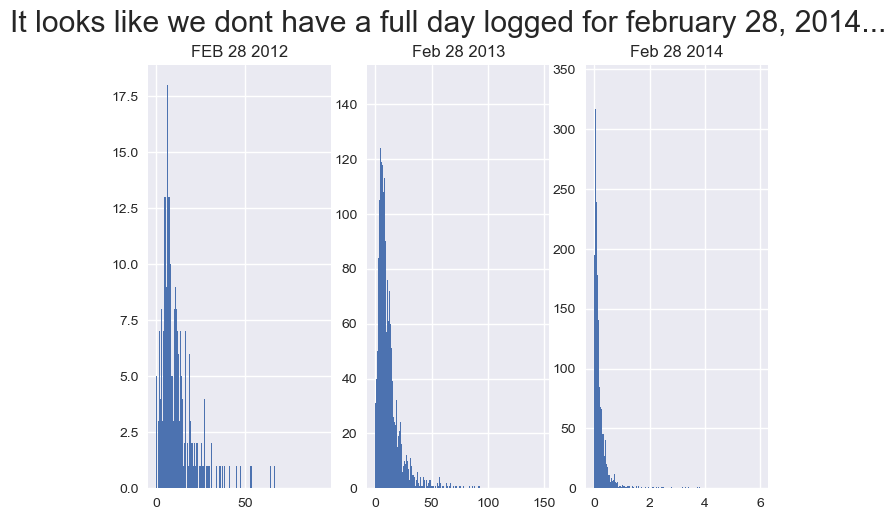

In [162]:
# this is the last date in most series 
fig, ax = plt.subplots(ncols=3)

ts.loc['2014-02-28','y'].hist(bins=500,
                            ax=ax[2])

ts.loc['2013-02-28','y'].hist(bins=500,
          ax=ax[1])

ts.loc['2012-02-28','y'].hist(bins=500,
          ax=ax[0])

fig.suptitle('It looks like we dont have a full day logged for february 28, 2014...')

ax[0].set_title('FEB 28 2012')

ax[1].set_title('Feb 28 2013')

ax[2].set_title('Feb 28 2014')

# we will drop this datapoint as it's the last day in most series

In [163]:
new_ts = new_ts.query('ds != "2014-02-28"') # drop this partial day, this will heavily skew our forecast....

In [164]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import SeasonalRollingMean, RollingMean, RollingStd
from utilsforecast.feature_engineering import trend, fourier, pipeline 
#from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from functools import partial 
from mlforecast.target_transforms import Differences
#create MLF with fourier features, it looks like our fourier features should perform well based on the ts we've seen. 
mlf_fourier = MLForecast(
    models = {'Linear':Ridge(),
              'hgbm':HistGradientBoostingRegressor(),
              'lgbm':LGBMRegressor(verbosity=-1),
              #"RandomForest":xgb.XGBRFRegressor()
              },
    freq='D',
    lags = [1,2,3,7,14,21, 90], #1,2,3,weekly.quarterly
    lag_transforms={1:[
        RollingMean(window_size=7,min_samples=1),
        RollingStd(window_size=7,min_samples=1),
        SeasonalRollingMean(window_size=8,
                            season_length=90,
                            min_samples=1)
    ]},
    num_threads=8,
    date_features=['quarter','year','month'],
    target_transforms=[Differences([1])]
)

In [165]:
new_ts.y = new_ts.groupby('unique_id').y.ffill().fillna(0)

In [166]:
# first lets fit a our global models to un-partitioned data and eval 

#create feature pipeline for each partition 
df_fourier,fut_h= pipeline(
features = [trend,
partial(fourier,season_length=7,k=5),
partial(fourier,season_length=28,k=5)],
freq='D',
h=7,
df=new_ts)

#fit model 
mlf_fourier.fit(df_fourier,
                static_features=[],
                as_numpy=True)


cv_df = mlf_fourier.cross_validation( # perform 3 month cross validation
    df_fourier,
  #  X_df=df_fourier,
    n_windows=5,
    h=7,
    refit=2, # refit everyother
as_numpy=True)

from utilsforecast.losses import rmse, mae ,smape 

rmse_dist = rmse(cv_df,
    models=['Linear','hgbm','lgbm']).set_index('unique_id')

mae_dist = mae(cv_df,
models=['Linear','hgbm','lgbm']).set_index('unique_id')

smape_dist = smape(cv_df,
    models=['Linear','hgbm','lgbm']
    ).set_index('unique_id')



In [167]:
rmse_global = rmse_dist.mean().to_frame('global_rmse_pooled')

mae_global = mae_dist.mean().to_frame('global_mae_pooled')

smape_global = smape_dist.mean().to_frame('global_smape_pooled')

global_metrics = rmse_global.join(mae_global).join(smape_global)

global_metrics

global_rmse_pooled  global_mae_pooled  global_smape_pooled
Linear            2.896530           2.214275             0.108850
hgbm              2.881884           2.233741             0.110220
lgbm              2.885328           2.238201             0.110761

In [168]:
#join then melt error dataframe to plot 
meltd_error = pd.concat([rmse_dist.assign(metric='rmse'),
           mae_dist.assign(metric='mean_abs_error'),
           smape_dist.assign(metric='smape')]).reset_index()\
.melt(id_vars=['unique_id','metric'],
var_name='model',
value_name='error')

#Plot error distribution 
px.histogram(meltd_error.query('metric != "smape"'),
             x='error',
             color='model',
             facet_col='metric',
             marginal='box',
             title='Error Distribution by Model (RMSE Left)/(MAE Right)',
             hover_data=['unique_id'],
             barmode='overlay',
             opacity=.5)

* looking at characteristics of the error distribution.

In [169]:
dist_char = meltd_error.groupby(['model','metric'])['error'].apply(lambda x: x.kurtosis()).to_frame('kurtosis')\
    .join(meltd_error.groupby(['model','metric'])['error'].skew().to_frame('skew'))

dist_char.unstack(1) # Random Forest has the lowest skew and kurtosis, that could tell us it is more consistent in simulated forecast error.

kurtosis                                 skew                    
metric mean_abs_error       rmse      smape mean_abs_error      rmse     smape
model                                                                         
Linear      18.791733  23.122535  43.046296       3.311237  3.627069  5.128705
hgbm        20.176677  22.640001  42.412917       3.399074  3.636926  5.055014
lgbm        20.143466  22.602072  42.279843       3.399090  3.638827  5.058390

In [170]:
# lets start exploring external covariates

dt_cols = [x for x in weather.columns if "time" in x]

weather[dt_cols] = weather[dt_cols].apply(lambda x: pd.to_datetime(x))

daily_weather = weather.set_index('sunrisetime').sort_index().resample('d').mean(numeric_only=True)

weather_feats = ['temperaturelow', 'temperaturehigh', 'cloudcover', 'uvindex',
       'humidity', 'temperaturemin', 'temperaturemax','dewpoint','pressure']

daily_weather = daily_weather[weather_feats]

daily_weather.head()

temperaturelow  temperaturehigh  cloudcover  uvindex  humidity  \
sunrisetime                                                                   
2011-11-01             8.88            15.57        0.36      1.0      0.84   
2011-11-02            13.99            15.06        0.39      1.0      0.87   
2011-11-03            12.52            17.41        0.52      1.0      0.89   
2011-11-04            10.17            15.54        0.50      1.0      0.91   
2011-11-05             9.46            13.94        0.65      1.0      0.92   

             temperaturemin  temperaturemax  dewpoint  pressure  
sunrisetime                                                      
2011-11-01             9.68           15.57     10.13   1009.46  
2011-11-02             8.88           15.19     10.23   1004.79  
2011-11-03            12.79           17.41     13.39    993.40  
2011-11-04            11.53           15.54     12.03    995.54  
2011-11-05            10.17           13.94     10.96   1007.39

* lets examine what features have cross correlation and causality in our total daily energy consumption... using Darts!

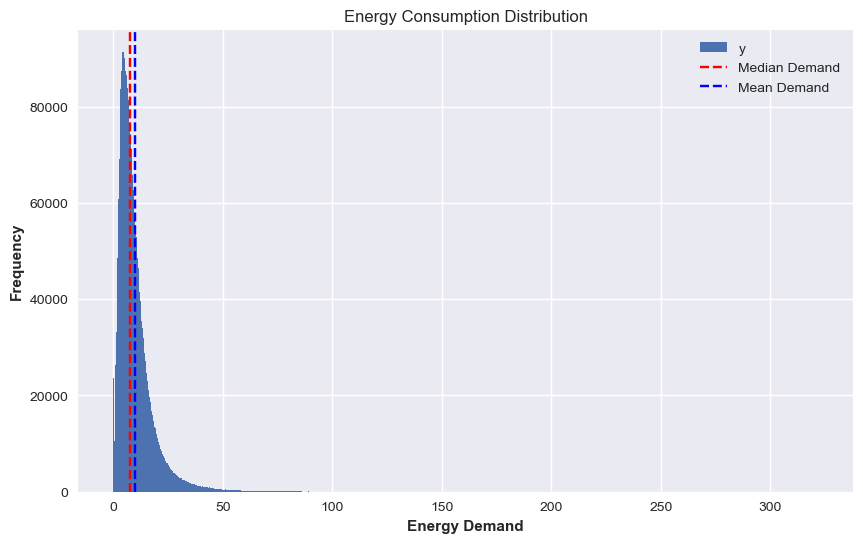

In [171]:
# given the computational complexity we can't select features for all 5k timeseries individually, so we'll aggregate the series 

plt.style.use('fast')

new_ts.plot.hist(y='y',
                 bins=1000,
                 figsize=(10,6),
                 xlabel='Energy Demand',
                 title='Energy Consumption Distribution')

plt.axvline(x=new_ts.y.median(),
            ymax=30_0000,
            label='Median Demand',
            linestyle='--',
            color='r')

plt.axvline(x=new_ts.y.mean(),
            ymax=30_0000,
            label='Mean Demand',
            linestyle='--',
            color='blue')

plt.legend() # we use median as it is more reliably measuring the central tendency of a Demand Distribution 

In [172]:
from darts.utils.statistics import grangercausalitytests, stationarity_tests,plot_ccf
from darts.timeseries import TimeSeries
from darts import concatenate

daily = new_ts.resample('d',on='ds').y.median()

data = daily_weather.join(daily).dropna().resample('d').median().ffill()# keep only data where consumption is not null

daily_weather_ts = TimeSeries.from_dataframe(data) # keep only data where demand is not null


In [173]:
# lets check stationarity of the timeseries components 

for comp in daily_weather_ts.components: 

    daily_ts = daily_weather_ts[comp].diff()

    print(f'We conclude at 95% confidence (1st difference) that {comp} being stationary is {stationarity_tests(daily_ts)}')

We conclude at 95% confidence (1st difference) that temperaturelow being stationary is True
We conclude at 95% confidence (1st difference) that temperaturehigh being stationary is True
We conclude at 95% confidence (1st difference) that cloudcover being stationary is True
We conclude at 95% confidence (1st difference) that uvindex being stationary is True
We conclude at 95% confidence (1st difference) that humidity being stationary is True
We conclude at 95% confidence (1st difference) that temperaturemin being stationary is True
We conclude at 95% confidence (1st difference) that temperaturemax being stationary is True
We conclude at 95% confidence (1st difference) that dewpoint being stationary is True
We conclude at 95% confidence (1st difference) that pressure being stationary is True
We conclude at 95% confidence (1st difference) that y being stationary is False


In [174]:
#significant_list = []

for ts in daily_weather_ts.components: 

    if ts == 'y': 
        continue 

    #test granger causality for linear relationship between all weather feats and y 

    to_test = daily_weather_ts[['y',ts]].diff() # difference the series to ensure stationarity 

    res = grangercausalitytests(to_test.values(), 
                                maxlag=[1,2,3,7], # test up to lag 7 
                                verbose=False)
    
    print(f'Does {ts} granger cause our target variable?')

    p_val = res[1][0]['ssr_ftest'][1]
    print(f'P-Value at lag 1: {p_val:.4f}')

    print('------------------------------')

    if p_val < .01:

        print(f'F-Test Statistic (Strength of Linear Relation/Granger Causality): {res[1][0]["ssr_ftest"][0]}')

        print()

Does temperaturelow granger cause our target variable?
P-Value at lag 1: 0.0004
------------------------------
F-Test Statistic (Strength of Linear Relation/Granger Causality): 12.476939545169595

Does temperaturehigh granger cause our target variable?
P-Value at lag 1: 0.0011
------------------------------
F-Test Statistic (Strength of Linear Relation/Granger Causality): 10.664708193768007

Does cloudcover granger cause our target variable?
P-Value at lag 1: 0.0008
------------------------------
F-Test Statistic (Strength of Linear Relation/Granger Causality): 11.225764877124377

Does uvindex granger cause our target variable?
P-Value at lag 1: 0.0809
------------------------------
Does humidity granger cause our target variable?
P-Value at lag 1: 0.0355
------------------------------
Does temperaturemin granger cause our target variable?
P-Value at lag 1: 0.0071
------------------------------
F-Test Statistic (Strength of Linear Relation/Granger Causality): 7.275987754639547

Does te

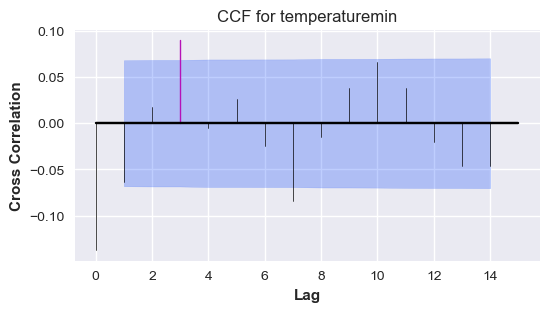

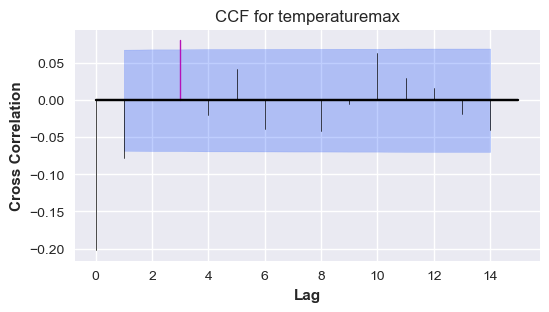

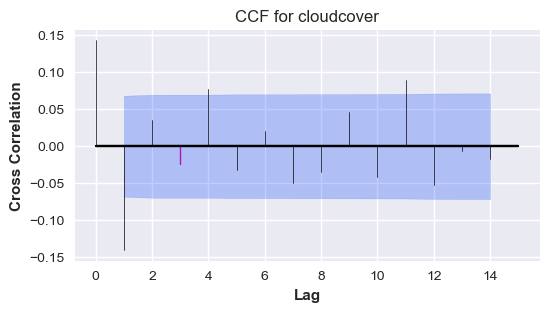

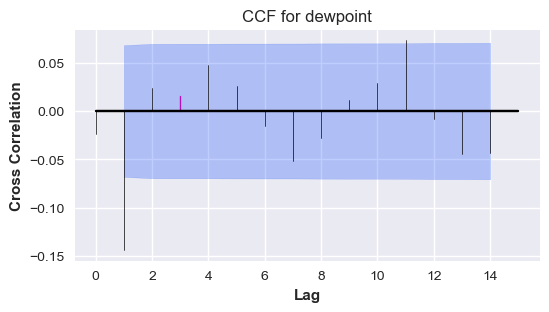

In [175]:
# we see the 3 strongest features are temperature high, cloud cover and temperature max (forecasted)

# we still have other features to use like templow, I think for this I am going to use templow, temphigh (actuals) and cloud cover. 

#lets check the CCF of our features of interest 

for feat in ['temperaturemin','temperaturemax','cloudcover','dewpoint']:

    to_plot = daily_weather_ts[['y',feat]].diff()

    fig, ax = plt.subplots(figsize = (6,3))

    plot_ccf(to_plot['y'],
             ts_other=to_plot[feat],
             max_lag=14,
             axis=ax,
             m=3) # highlight lag 3 as it is significant in temp max/min

    ax.set_title(f'CCF for {feat}')

    ax.set_ylabel('Cross Correlation')

    ax.set_xlabel('Lag')

* we can likely add these features to the model given what we know, but temp min/max will clearly have multicolinearity issues. 

* so lets see if we can engineer a new feature to capture the information and decorrelate the two. 

Text(0.5, 0, 'Lag')

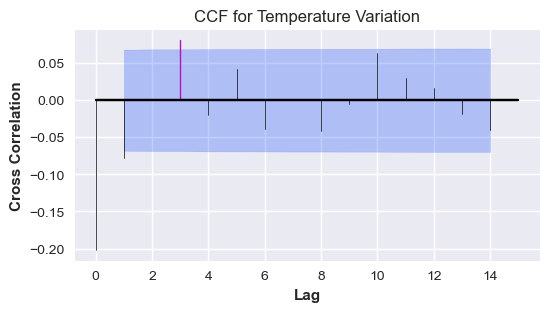

In [176]:
temp_var = daily_weather_ts['temperaturemax'] - daily_weather_ts['temperaturemin']

new = concatenate([temp_var,daily_weather_ts],axis=1)

fig, ax = plt.subplots(figsize = (6,3))

plot_ccf(new['y'].diff(),
            ts_other=new['temperaturemax_1'].diff(),
            max_lag=14,
            axis=ax,
            m=3) # highlight lag 3 as it is significant in temp max/min

ax.set_title(f'CCF for Temperature Variation')

ax.set_ylabel('Cross Correlation')

ax.set_xlabel('Lag')

array([<Axes: xlabel='sunrisetime'>, <Axes: xlabel='sunrisetime'>,
       <Axes: xlabel='sunrisetime'>, <Axes: xlabel='sunrisetime'>],
      dtype=object)

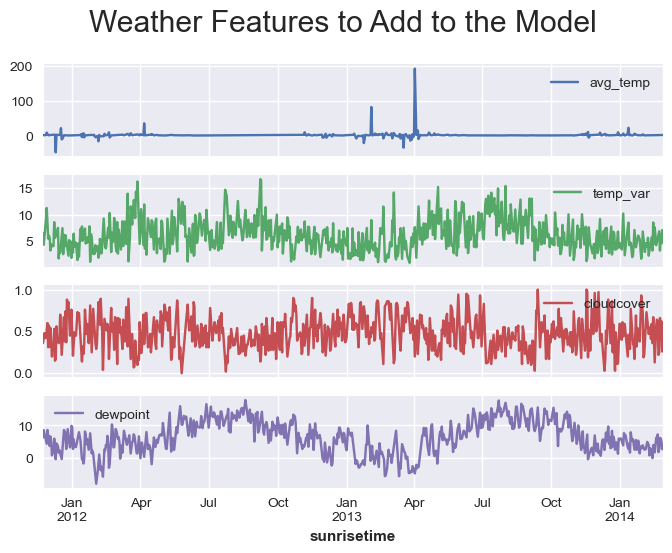

In [177]:
weather_feats = data.assign(avg_temp = data['temperaturemax'].div(data['temperaturemin']),
            temp_var = data['temperaturemax'] - data['temperaturemin'])[['avg_temp','temp_var','cloudcover','dewpoint']]


weather_feats.plot(subplots=True,title='Weather Features to Add to the Model')

# it looks like when plotting, we see some huge outliers, (sensor failures is likely the cause)

In [178]:
weather_feats.loc['2013-04']['avg_temp']

outlier_indices = ['2013-02-03','2013-04-02']

weather_feats_new = weather_feats.assign(month = weather_feats.index.month,
                     day = weather_feats.index.day,
                     year = weather_feats.index.year)

#fill with mean profile of the series for each outlier datapoint
feb_val = weather_feats_new.query('day == 3 & month == 2 & year != 2013')['avg_temp'].mean()

april_val = weather_feats_new.query('day == 2 & month == 4 & year != 2013')['avg_temp'].mean()

weather_feats.loc[outlier_indices,'avg_temp'] = np.nan 

#fill values on indices
weather_feats = weather_feats.fillna(feb_val,limit=1).fillna(april_val)

* create rolling and lag features from weather feats using sktime

In [179]:
from sktime.transformations.series.summarize import WindowSummarizer 

from sklearn import set_config 

set_config(transform_output='pandas')

window_feats = WindowSummarizer(
    lag_feature={'lag':[1,2,3,4,5,6,7],
                 'mean':[[1,7]],
                 'std':[[1,7]]},
    n_jobs=-1,
    target_cols = weather_feats.columns,
    truncate='bfill'
)

#now lets standard scale our variables. 

from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline 

scaler = StandardScaler() 

window_pipe = make_pipeline(window_feats,scaler)

weather_feats_ = window_pipe.fit_transform(weather_feats)

In [180]:
df_fourier_weather = df_fourier.merge(weather_feats_,
                                      left_on='ds',
                                      right_index=True)

In [207]:
df_fourier_weather

unique_id         ds       y  trend    sin1_7    sin2_7    sin3_7  \
0        MAC000002 2012-10-12   7.098  325.0  0.433873 -0.781816  0.974940   
1        MAC000002 2012-10-13  11.087  326.0 -0.433881  0.781828 -0.974919   
2        MAC000002 2012-10-14  13.223  327.0 -0.974931  0.433861  0.781817   
3        MAC000002 2012-10-15  10.257  328.0 -0.781833 -0.974927 -0.433878   
4        MAC000002 2012-10-16   9.769  329.0  0.000013  0.000027 -0.000051   
...            ...        ...     ...    ...       ...       ...       ...   
3510442  MAC005567 2014-02-23   3.942  824.0 -0.974927  0.433891  0.781710   
3510443  MAC005567 2014-02-24   4.107  825.0 -0.781843 -0.974920 -0.433778   
3510444  MAC005567 2014-02-25   5.762  826.0  0.000027  0.000055 -0.000040   
3510445  MAC005567 2014-02-26   5.066  827.0  0.781839  0.974922  0.433850   
3510446  MAC005567 2014-02-27   3.217  828.0  0.974928 -0.433879 -0.781912   

           sin4_7    sin5_7    cos1_7  ...  cloudcover_std_1_7  \
0       -0.974939  0.781812 -0.900974  ...           -0.044922   
1        0.974930 -0.781821 -0.900970  ...           -0.103404   
2       -0.781800 -0.433831 -0.222509  ...            0.226810   
3        0.433892  0.974930  0.623488  ...            0.456635   
4        0.000054 -0.000085  1.000000  ...            0.498844   
...           ...       ...       ...  ...                 ...   
3510442 -0.781841 -0.433811 -0.222525  ...            1.057567   
3510443  0.433952  0.974935  0.623475  ...            0.511403   
3510444  0.000109  0.000014  1.000000  ...            0.479213   
3510445 -0.433928 -0.974887  0.623480  ...            0.559118   
3510446  0.781825  0.434005 -0.222519  ...            0.695551   

         dewpoint_lag_1  dewpoint_lag_7  dewpoint_lag_2  dewpoint_lag_6  \
0              0.819731        0.709591       -0.070400        0.150253   
1              0.107531        0.149240        0.819155        0.176728   
2             -0.081711        0.175729        0.106697        0.746948   
3             -0.498858        0.746269       -0.082614        0.374269   
4             -0.032875        0.373381       -0.499911       -0.071725   
...                 ...             ...             ...             ...   
3510442       -0.795947       -0.979613       -0.961991       -0.314069   
3510443       -0.077642       -0.315342       -0.797108       -0.067652   
3510444       -0.106130       -0.068788       -0.078543       -0.191879   
3510445       -0.303511       -0.193084       -0.107041        0.135998   
3510446       -0.775599        0.134977       -0.304494       -0.963713   

         dewpoint_lag_3  dewpoint_lag_5  dewpoint_lag_4  dewpoint_mean_1_7  \
0              0.375113        0.177558        0.747588           0.463130   
1             -0.070706        0.747560        0.375051           0.366774   
2              0.818898        0.375023       -0.070771           0.329465   
3              0.106400       -0.070800        0.818838           0.221430   
4             -0.082921        0.818810        0.106337           0.096850   
...                 ...             ...             ...                ...   
3510442        0.136936       -0.066729       -0.190878          -0.505939   
3510443       -0.962346       -0.190908        0.136872          -0.362866   
3510444       -0.797454        0.136843       -0.962415          -0.330098   
3510445       -0.078849       -0.962446       -0.797522          -0.368056   
3510446       -0.107349       -0.797553       -0.078914          -0.461492   

         dewpoint_std_1_7  
0               -0.590363  
1               -0.652829  
2               -0.471326  
3                0.172040  
4               -0.194864  
...                   ...  
3510442          0.037119  
3510443         -0.247454  
3510444         -0.198403  
3510445         -0.270815  
3510446         -0.114558  

[3257567 rows x 60 columns]

In [181]:
#make sure we are using yesterdays weather

#refit model  with new features 
mlf_fourier.fit(df_fourier_weather,
                static_features=[],
                as_numpy=True)


cv_df = mlf_fourier.cross_validation( # perform 5 wk cross validation
    df_fourier_weather,
  #  X_df=df_fourier,
    n_windows=5,
    h=7,
    static_features=[],
    as_numpy=True,
    refit=2
    
)

from utilsforecast.losses import rmse, mae ,smape 

rmse_dist_weather = rmse(cv_df,
    models=['Linear','hgbm','lgbm']).set_index('unique_id')

mae_dist_weather = mae(cv_df,
models=['Linear','hgbm','lgbm']).set_index('unique_id')

smape_dist_weather = smape(cv_df,
    models=['Linear','hgbm','lgbm']
    ).set_index('unique_id')



* lets look at feature importance, in the linear model and random forest.

In [182]:
linear_imps = {}
tree_imps = {}
for i in range(2):

    linear_imps[f'fold_{i}'] = (mlf_fourier.cv_models_[i]['Linear'].coef_)
    tree_imps[f'fold_{i}'] = (mlf_fourier.cv_models_[i]['lgbm'].feature_importances_)

In [183]:
feats = mlf_fourier.preprocess(df_fourier_weather).drop(columns=['y','ds','unique_id']).columns

linear_coefs = pd.DataFrame(linear_imps).set_index(feats).mean(axis=1)

tree_imps = pd.DataFrame(tree_imps).set_index(feats).mean(axis=1)

<Axes: title={'center': 'lgbm Importance of Features (5 Fold CV)'}, xlabel='Coefficient', ylabel='Feature'>

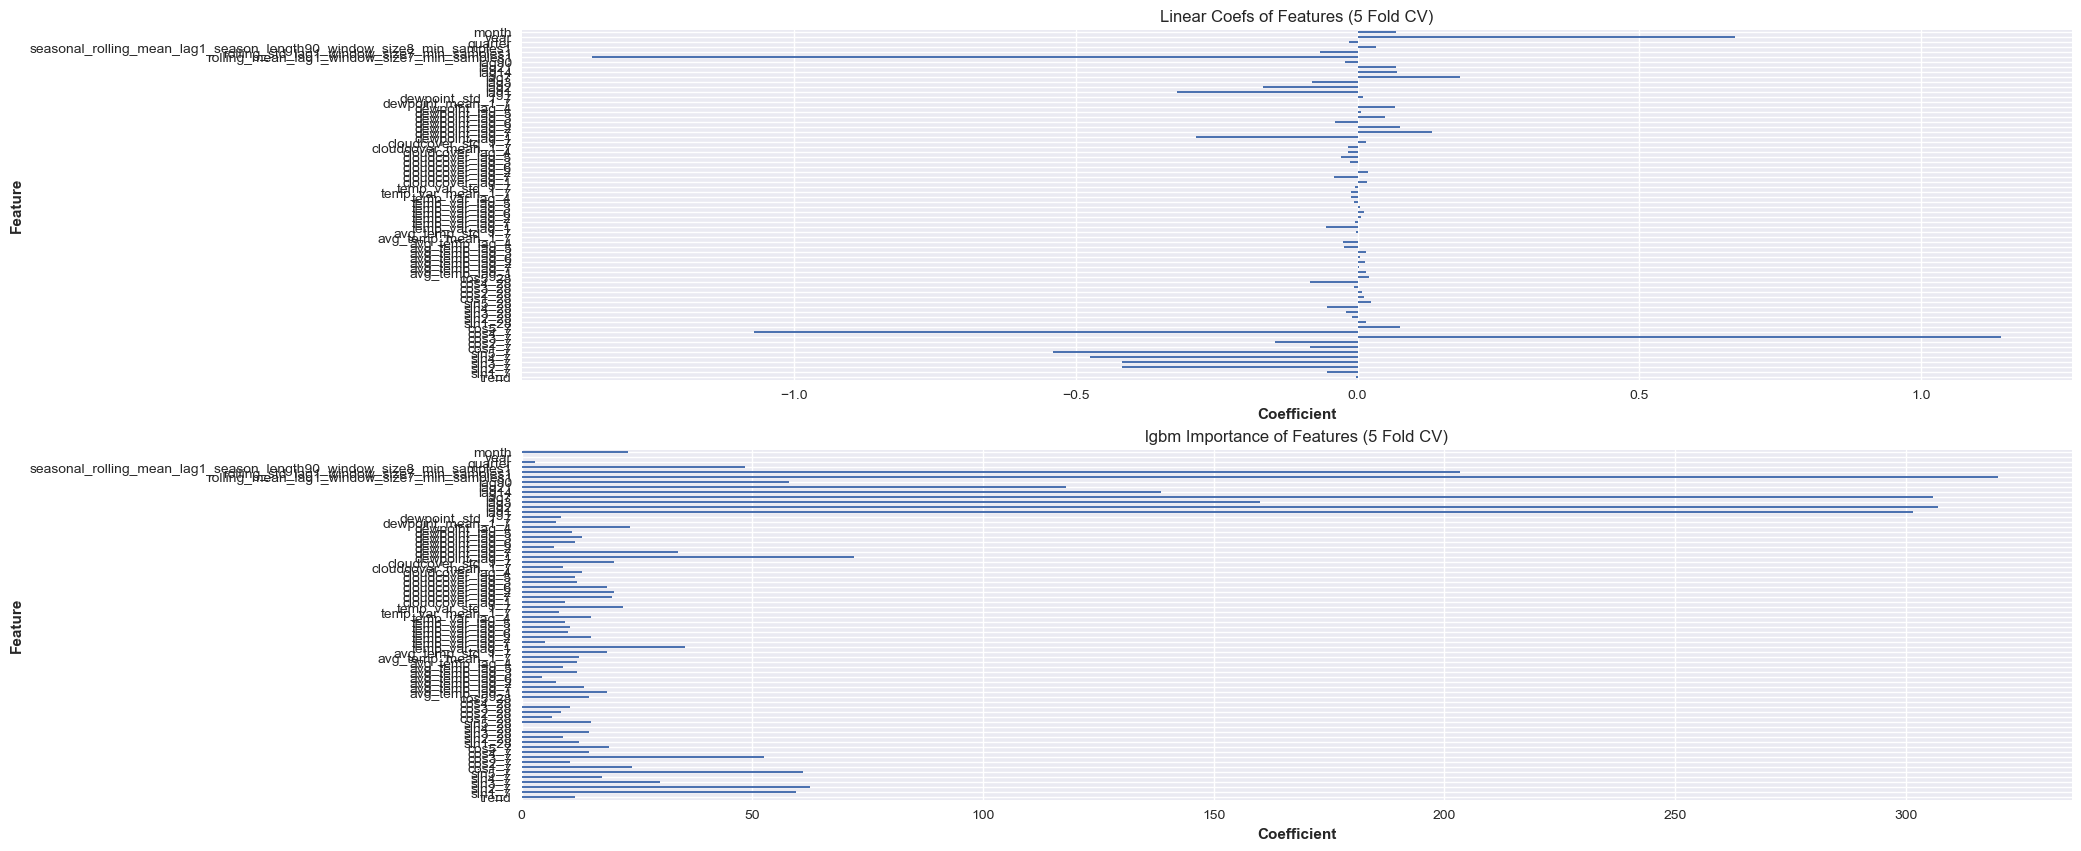

In [184]:
fig,ax = plt.subplots(figsize=(20,10),
                      nrows=2,
                      sharey=True)

linear_coefs.plot(kind='barh',
                  title='Linear Coefs of Features (5 Fold CV)',
                  ylabel='Feature',
                  xlabel='Coefficient',
                  ax=ax[0])

tree_imps.plot(kind='barh',
                  title='lgbm Importance of Features (5 Fold CV)',
                  ylabel='Feature',
                  xlabel='Coefficient',
                  ax=ax[1])

* looks like both models could use a bit of regularization to avoid overfitting, overall we see the weather features are adding to the model(s)

In [185]:
meltd_weather_error = pd.concat([rmse_dist_weather.assign(metric='rmse'),
           mae_dist_weather.assign(metric='mean_abs_error'),
           smape_dist_weather.assign(metric='smape')]).reset_index()\
.melt(id_vars=['unique_id','metric'],
var_name='model',
value_name='error')

In [186]:
meltd_comp = pd.concat([meltd_error.assign(feats = 'no_weather'),
           meltd_weather_error.assign(feats='weather')])

In [187]:
px.histogram(meltd_comp.query('metric != "smape"'),
             color='feats',
             x='error',
             facet_col='model',
             facet_row='metric',
             histnorm='probability density',
             marginal='box',
             barmode='overlay')

In [188]:
meltd_comp.groupby(['model','metric','feats']).error.mean().unstack(0) # it doesn't seem like weather features add much to the model 

model                        Linear      hgbm      lgbm
metric         feats                                   
mean_abs_error no_weather  2.214275  2.233741  2.238201
               weather     2.245434  2.269546  2.268203
rmse           no_weather  2.896530  2.881884  2.885328
               weather     2.905432  2.905745  2.905294
smape          no_weather  0.108850  0.110220  0.110761
               weather     0.112919  0.112607  0.112662

* lets add holidays and encode unique id using catboost encoder.  

In [189]:
import holidays 
from sktime.transformations.series.holiday import HolidayFeatures

gb_holidays = holidays.country_holidays(country='GB',
                                        years=[2011,2012,2013,2014])

holidays_trns = HolidayFeatures(calendar=gb_holidays,
                include_bridge_days=True,
                return_indicator=True,
                return_dummies=False)

holidays_insample = holidays_trns.fit_transform(df_fourier[['ds']].resample('d',on='ds').sum())

In [190]:
#target encoding using catboost encoder
from category_encoders import CatBoostEncoder
#create train/test split, strictly for encoding. 

cbe = CatBoostEncoder(verbose=False,
                      cols=['unique_id_new'])

#drop the cross validation span indices to avoid data leakage
test_set = df_fourier_weather.groupby('unique_id').tail(35)

train_set = df_fourier_weather.drop(test_set.index)

In [191]:
train_new = cbe.fit_transform(train_set.assign(unique_id_new = train_set.unique_id),
                  train_set['y'])

df_fourier_weather_new = pd.concat([train_new,test_set.assign(unique_id_new = test_set.unique_id.map(cbe.mapping['unique_id_new']['sum'])) # map categorical features to test set 
])\
    .join(holidays_insample,on='ds',how='left')

In [192]:
df_fourier_weather_new = df_fourier_weather_new.assign(unique_id_new = df_fourier_weather_new['unique_id_new']\
    .div(df_fourier_weather_new['unique_id_new'].max())) # scale new feature 

In [193]:
#make sure we are using yesterdays weather

#refit model  with new features 
mlf_fourier.fit(df_fourier_weather_new,
                static_features=['unique_id_new'],
                as_numpy=True)


cv_df = mlf_fourier.cross_validation( # perform 5 wk cross validation
    df_fourier_weather_new,
  #  X_df=df_fourier,
    n_windows=5,
    h=7,
    static_features=['unique_id_new'],
    as_numpy=True,
    refit=2 
)

from utilsforecast.losses import rmse, mae ,smape 

rmse_dist_weather = rmse(cv_df,
    models=['Linear','hgbm','lgbm']).set_index('unique_id')

mae_dist_weather = mae(cv_df,
models=['Linear','hgbm','lgbm']).set_index('unique_id')

smape_dist_weather = smape(cv_df,
    models=['Linear','hgbm','lgbm']
    ).set_index('unique_id')


In [194]:
weather_cats = pd.concat([rmse_dist_weather.assign(metric='rmse'),
           mae_dist_weather.assign(metric='mean_abs_error'),
           smape_dist_weather.assign(metric='smape')]).reset_index()\
.melt(id_vars=['unique_id','metric'],
var_name='model',
value_name='error')

new_eval = pd.concat([meltd_comp,weather_cats.assign(feats = 'cats_and_holidays')])

new_eval.groupby(['model','metric','feats']).error.mean().unstack(0)

model                               Linear      hgbm      lgbm
metric         feats                                          
mean_abs_error cats_and_holidays  3.097184  2.369729  2.320041
               no_weather         2.214275  2.233741  2.238201
               weather            2.245434  2.269546  2.268203
rmse           cats_and_holidays  4.181746  3.010230  2.960106
               no_weather         2.896530  2.881884  2.885328
               weather            2.905432  2.905745  2.905294
smape          cats_and_holidays  0.140359  0.121645  0.117868
               no_weather         0.108850  0.110220  0.110761
               weather            0.112919  0.112607  0.112662

* lets merge in acorn groupings, split the data by group and retrain our models! 

In [195]:
df_full = df_fourier_weather_new.merge(acorn_info[['lclid','acorn_grouped']],
left_on='unique_id',
right_on='lclid',
)

In [196]:
part_1 = df_full.query('acorn_grouped == "Affluent"')

part_2 = df_full.query('acorn_grouped == "Adversity"')

part_3 = df_full.query('acorn_grouped == "Comfortable"')

part_4 = df_full.query('acorn_grouped not in ("Affluent","Adversity","Comfortable")')

In [197]:
#train a model for each partition, combine scores and re-evaluate the model 
part_scores = []

#zip df dict 
df_dict = dict(zip(['Affluent','Adversity','Comfortable','Other'],[part_1,part_2,part_3,part_4]))

all_dfs = [] # curious to compute error metrics on the entire df rather than pooling 

for acorn_group, part_df in df_dict.items(): 

    part_df = part_df.drop(columns=['lclid','acorn_grouped'])

    #refit model  with new features 
    mlf_fourier.fit(part_df,
                    static_features=['unique_id_new'],
                    as_numpy=True)


    cv_df = mlf_fourier.cross_validation( # perform 5 wk cross validation
        part_df,
    #  X_df=df_fourier,
        n_windows=5,
        h=7,
        static_features=['unique_id_new'],
        as_numpy=True,
        refit=2 
    )

    from utilsforecast.losses import rmse, mae ,smape 

#compute all error metrics 
    rmse_dist_weather = rmse(cv_df,
        models=['Linear','hgbm','lgbm']).set_index('unique_id')

    mae_dist_weather = mae(cv_df,
    models=['Linear','hgbm','lgbm']).set_index('unique_id')

    smape_dist_weather = smape(cv_df,
        models=['Linear','hgbm','lgbm']
        ).set_index('unique_id')

#melt dataframes and compute error, assign part_id_column 
    error_df = pd.concat([rmse_dist_weather.assign(metric='rmse'),
           mae_dist_weather.assign(metric='mean_abs_error'),
           smape_dist_weather.assign(metric='smape')]).reset_index()\
    .melt(id_vars=['unique_id','metric'],
    var_name='model',
    value_name='error')

    all_dfs.append(cv_df)

    error_df = error_df.assign(acorn_grouped = acorn_group)

    part_scores.append(error_df)

* lets evaluate how our models did when partitioned by acorn group...

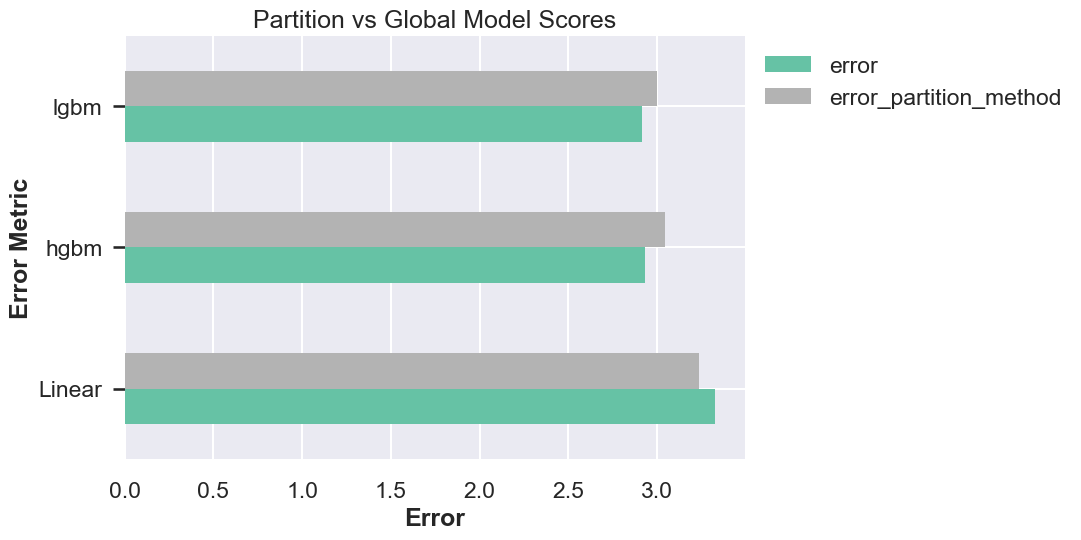

In [198]:
partition_scores = pd.concat(part_scores)


pooled_partition_scores = partition_scores.groupby(['model','metric'])[['error']].mean()

partition_vs_global = new_eval.groupby(['model','metric'])[['error']].mean()\
    .join(pooled_partition_scores,rsuffix='_partition_method')


sns.set_context('talk')

partition_vs_global.swaplevel(0,1).loc['rmse'].plot.barh(title='Partition vs Global Model Scores',
cmap='Set2',
ylabel='Error Metric',
xlabel='Error') # it looks like partitioning makes the model worse in our case, LOLLLL

plt.legend(bbox_to_anchor=(1,1))

In [199]:
new_eval.groupby(['model','metric','feats']).error.mean().unstack(0)

model                               Linear      hgbm      lgbm
metric         feats                                          
mean_abs_error cats_and_holidays  3.097184  2.369729  2.320041
               no_weather         2.214275  2.233741  2.238201
               weather            2.245434  2.269546  2.268203
rmse           cats_and_holidays  4.181746  3.010230  2.960106
               no_weather         2.896530  2.881884  2.885328
               weather            2.905432  2.905745  2.905294
smape          cats_and_holidays  0.140359  0.121645  0.117868
               no_weather         0.108850  0.110220  0.110761
               weather            0.112919  0.112607  0.112662

* welp, it looks like adding features continued to make the model worse, lets retrain our model and forecast.

<Axes: title={'center': 'Feature Sets and How They Effect RMSE.'}, xlabel='Error', ylabel='Feature Set'>

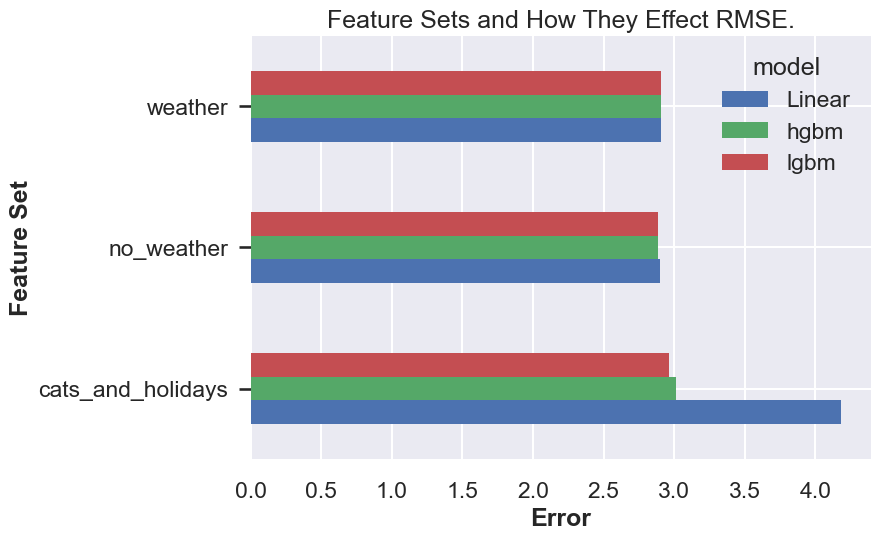

In [200]:
new_eval.groupby(['model','metric','feats']).error.mean().unstack(0).loc['rmse'].plot.barh(title='Feature Sets and How They Effect RMSE.',
xlabel='Error',
ylabel='Feature Set')

In [201]:
df_fourier.head(), df_fourier.columns

(   unique_id         ds       y  trend    sin1_7    sin2_7    sin3_7  \
 0  MAC000002 2012-10-12   7.098  325.0  0.433873 -0.781816  0.974940   
 1  MAC000002 2012-10-13  11.087  326.0 -0.433881  0.781828 -0.974919   
 2  MAC000002 2012-10-14  13.223  327.0 -0.974931  0.433861  0.781817   
 3  MAC000002 2012-10-15  10.257  328.0 -0.781833 -0.974927 -0.433878   
 4  MAC000002 2012-10-16   9.769  329.0  0.000013  0.000027 -0.000051   
 
      sin4_7    sin5_7    cos1_7  ...   sin1_28   sin2_28   sin3_28   sin4_28  \
 0 -0.974939  0.781812 -0.900974  ... -0.623492  0.974929 -0.900975  0.433873   
 1  0.974930 -0.781821 -0.900970  ... -0.781831  0.974928 -0.433893 -0.433881   
 2 -0.781800 -0.433831 -0.222509  ... -0.900970  0.781828  0.222515 -0.974931   
 3  0.433892  0.974930  0.623488  ... -0.974928  0.433885  0.781830 -0.781833   
 4  0.000054 -0.000085  1.000000  ... -1.000000 -0.000007  1.000000  0.000013   
 
     sin5_28   cos1_28   cos2_28   cos3_28   cos4_28   cos5_28  
 0  0.2

* reinstantiate our ml forecaster just for visibility sake.

In [202]:
mlf_fourier = MLForecast(
    models = {'Linear':Ridge(),
              'hgbm':HistGradientBoostingRegressor(),
              'lgbm':LGBMRegressor(verbosity=-1,
                                   linear_tree=True),
              #"RandomForest":xgb.XGBRFRegressor()
              },
    freq='D',
    lags = [1,2,3,7,14,21], #1,2,3,weekly.quarterly
    lag_transforms={1:[
        RollingMean(window_size=7,min_samples=1),
        RollingStd(window_size=7,min_samples=1),
        SeasonalRollingMean(window_size=8,
                            season_length=90,
                            min_samples=1)
    ]},
    num_threads=8,
    date_features=['quarter','year','month'],
    target_transforms=[Differences([1])]) 

In [203]:
new_ts = new_ts.query('ds != "2014-02-28"')  # drop this row as it skews our model's predictions. 

In [208]:
#create feature pipeline and create 2 weeks future features 
df_fourier,fut_h= pipeline(
features = [trend,
partial(fourier,season_length=7,k=5),
partial(fourier,season_length=28,k=5)
],
freq='D',
h=7,
df=new_ts)

#fit model 
mlf_fourier.fit(df_fourier_weather,
                static_features=[],
                as_numpy=True)

: 